# Yelp Data Challenge - Clustering and PCA

## Main tasks
1. Read in the dataset
2. Data preprocessing
    - 2.1 Define feature variables
    - 2.2 Define the target variable
    - 2.3 Create train and test datasets
    - 2.4 Get NLP representation of the documents
3. Cluster reviews with KMeans
    - 3.1 Fit k-means clustering with the train vectors and apply it on all the data
    - 3.2 Make predictions on all data
    - 3.3 Inspect the centroids
    - 3.4 Try using different k (clusters)
4. Cluster all the reviews of the most reviewed restaurant
    - 4.1 Vectorize the text feature
    - 4.2 Define the target variable
    - 4.3 Create train and test datasets
    - 4.4 Get NLP representation of the documents
    - 4.5 Cluster reviews with KMeans
5. Use PCA to reduce dimensionality
    - 5.1 Stardardize features
    - 5.2 Use PCA to transform data (train and test) and get princial components
    - 5.3 See how much (and how much percentage of) variance the principal components explain
    - 5.4 Plot proportion of variance explained with top K principal components
6. Classifying positive/negative review with PCA preprocessing
    - 6.1 Logistic Regression Classifier
        - 6.1.1 Use standardized tf-idf vectors as features
        - 6.1.2 Use (Stardardized + PCA) tf-idf vectors as features
        - 6.1.3 Summary
        - 6.1.4 Visualization: PCA components 
    - 6.2 Random Forest Classifier
        - 6.2.1 Use standardized tf-idf vectors as features
        - 6.2.2 Use (Stardardized + PCA) tf-idf vectors as features
        - 6.2.3 Summary
        - 6.2.4 Visualization: PCA components
7. Other improvements for this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

### 1. Read in the dataset

In [2]:
df = pd.read_csv('./dataset/last_2_years_restaurant_reviews.csv', encoding = 'utf-8')

In [3]:
df.head()

,business_id,name,categories,avg_stars,cool,funny,review_id,stars,text,useful,user_id,count,text_length
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,6SgvNWJltnZhW7duJgZ42w,5,This is mine and my fiancé's favorite steakhou...,0,oFyOUOeGTRZhFPF9uTqrTQ,1,341
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,iwx6s6yQxc7yjS7NFANZig,4,Nice atmosphere and wonderful service. I had t...,0,2aeNFntqY2QDZLADNo8iQQ,1,417
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,UVUMu_bELdA56Ryfbur-DA,5,Every year a group of us (we had 6 this year) ...,1,gmPP4YFrgYsYQqPYokMgFA,1,493
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,UxFpgng8dPMWOj99653k5Q,5,Truly Fantastic! Best Steak ever. Service was...,0,aVOGlN9fZ-BXcbtj6dbf0g,1,152
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,Xp3ppynEvVu1KxDHQ3ae8w,5,Delmonico Steakhouse is a steakhouse owned by ...,0,KC8H7qTZVPIEnanw9fG43g,1,914


In [4]:
# Use a subset of the original df due to the computation limit
# Originally I have 515752 records
# Select 40% of 515752 records 
print(df.shape)
df = df.sample(frac=0.4, replace=False, random_state=0)
print(df.shape)

(515752, 13)
(206301, 13)


## 2. Data preprocessing
- 2.1 Define feature variables
- 2.2 Define the target variable
- 2.3 Create train and test datasets
- 2.4 Get NLP representation of the documents

### 2.1 Define feature variables

In [5]:
# Take the values of the column that contains review text data, and save to a variable named "documents"
documents = df.text.values
print(len(documents))

206301


### 2.2 Define the target variable 
- Any categorical variable that may be meaningful. For example, I defined the target variable into two labels, perfect (5 stars) and imperfect (1-4 stars) rating.

In [6]:
# The target column contains boolean values, either 1 (stars > 4) or 0 (stars <= 4)
df['target'] = (df.stars > 4).values

target = df['target'].values

print(target[0:5])
print(type(target))
print(type(target[0]))

# The ration between 1 and 0 is balanced
print(sum(target == 1))
print(sum(target == 0))

[False False  True  True False]
<class 'numpy.ndarray'>
<class 'numpy.bool_'>
95767
110534


In [7]:
# Look at the statistics of the target variable
print('mean:', np.mean(target))
print('sd:', np.std(target))

mean: 0.4642100619967911
sd: 0.49871743536568525


### 2.3 Create train and test datasets

In [8]:
from sklearn.cross_validation import train_test_split

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# X: documents
# Y: targets
# Now split the data into train and test sets (80% & 20%)
documents_train, documents_test, target_train, target_test = train_test_split(documents,
                                                                              target,
                                                                              test_size = 0.2,
                                                                              random_state = 0)

In [10]:
# Manually look over some sample data
print(documents_train[0:3])
print()
print(documents_test[0:3])
print(target_train[0:3])
print()
print(target_test[0:3])

['My wife and I went with our parents a few weeks ago. By far the best fish I have ever had! Between the 6 of us we had a lot of their dinner specials, they were all excellent. I tried their watermelon martini it was amazing. My wife and I agreed their drinks were so good we would go back just for a drink sometime.'
 'Great service. Interesting food and beverage menu. Nice ambience. An elevated departure from the Freemont St type places.'
 'I was seduced by the four star average on Yelp, even though my intuition told me "run away Simba and never return."  Our first (and last) dinner at McCall\'s was an unmitigated disaster.  The food was terrible.  My daughter recognized the rib sauce "from Costco" and my filet was tasteless and poorly prepared.  The breaded mushroom garnish became the joke of the night.  The only bright spot was Ken our server, who was a gentleman and very gracious.  It would have been far better if I had just burned the $120, then we would not all feel sick.']

["My 

### 2.4 Get NLP representation of the documents

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Create a TfidfVectorizer, and name it vectorizer
# Choose a reasonable max_features, e.g. use 2000 to fast the computation speed
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

In [13]:
# Fit and transform the TfidfVectorizer with the train data only, then tranform all the data to tf-idf
# Becuase in a real world situation, we assumed we only have the train data
vectors_train = vectorizer.fit_transform(documents_train).toarray()
print(vectors_train.shape)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(165040, 2000)


In [14]:
# Get the vocabularies
vocab = vectorizer.get_feature_names()

# max_features = 2000
print(len(vocab))

2000


In [15]:
# Use the fitted TfidfVectorizer to transform all the reviews
vectors_documents = vectorizer.transform(documents).toarray()
print(vectors_documents.shape)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(206301, 2000)


## 3. Cluster reviews with KMeans
- 3.1 Fit k-means clustering with the train vectors and apply it on all the data
- 3.2 Make predictions on all data
- 3.3 Inspect the centroids
- 3.4 Try using different k (clusters)

### 3.1 Fit k-means clustering with the train vectors and apply it on all the data

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans()

kmeans.fit(vectors_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### 3.2 Make predictions on all data

In [17]:
predict_cluster = kmeans.predict(vectors_documents)

### 3.3 Inspect the centroids
- Description: To find out what "topics" Kmeans has discovered we must inspect the centroids. Print out the centroids of the Kmeans clustering. These centroids are simply a bunch of vectors.  To make sense of them we need to map these vectors back into our 'word space'.  Think of each feature/dimension of the centroid vector as representing the "average" review or the average occurances of words for that cluster.
- Solution: Find the top 10 features (words) within each cluster. 
- Steps: 
    (1) Sort each centroid vector to find the top 10 features 
    (2) Go back to our vectorizer object to find out what words each of these features corresponds to

In [18]:
# Default of kmeans uses 8 clusters
# 2000 features (words) I have
kmeans.cluster_centers_.shape

(8, 2000)

In [19]:
len(vocab)

2000

In [20]:
# For each cluster's centroid, collect corresponding indexes (position) for top 10 words 
index_by_centroid = []
for centroid in kmeans.cluster_centers_:
    index_ls = np.argsort(centroid)[::-1][:10]
    index_by_centroid.append(index_ls)

In [21]:
index_by_centroid

[array([1293,  676,  167, 1878,  473,   65, 1003,  966, 1546, 1790]),
 array([1729, 1468, 1293, 1466,  120,  760,  745,  658, 1546,  692]),
 array([ 310,  695,  676, 1452,  745, 1199, 1293,  760,  473, 1502]),
 array([1291,  438,  745, 1293,  760, 1592,  301, 1260,  909,  167]),
 array([ 745,  676, 1403, 1293, 1546, 1142, 1343,  966,  909,  760]),
 array([ 760,  676, 1546, 1293,   65,  697,  116, 1661,  471,  105]),
 array([ 676, 1198, 1091, 1546, 1790,  909,  259,  489,  749, 1733]),
 array([ 238,  699,  239,  745, 1553,  301, 1293,  760,  676,  909])]

In [24]:
# Print out the corresponding top 10 words by indexes
for number, index_ls in enumerate(index_by_centroid):
    print("Cluster "+str(number)+":", ", ".join(vocab[i] for i in index_ls))

Cluster 0: place, food, best, vegas, delicious, amazing, love, like, service, time
Cluster 1: sushi, rolls, place, roll, ayce, great, good, fish, service, fresh
Cluster 2: chicken, fried, food, rice, good, ordered, place, great, delicious, sauce
Cluster 3: pizza, crust, good, place, great, slice, cheese, pepperoni, just, best
Cluster 4: good, food, really, place, service, nice, pretty, like, just, great
Cluster 5: great, food, service, place, amazing, friendly, awesome, staff, definitely, atmosphere
Cluster 6: food, order, minutes, service, time, just, came, didn, got, table
Cluster 7: burger, fries, burgers, good, shake, cheese, place, great, food, just


### 3.4 Try using different k (clusters)
- Q1: Why using 5 clusters? 
    1. Using eight clusters (default setting in kmeans), I found that three clusters are kind of similar to each other.
    2. The rest of clusters have some significant meanings such as in Cluster 1, it mainly tell about Japanese restaurants, and in Cluster 2 and 7, they might signify fast food restaurants. 
- Q2: How does the top features change after using 5 clusters?
    1. Using five clusters, the difference among clusters stands out more significant than using eight clusters. Each cluster now has an unique topic, such as Cluster 0 is mainly about service aspect, Cluster 1 is relating to the pizza, and Cluster 2 is surrounding with the topic of chicken in vegas.
    2. However, the top features using five clusters seem to be highly overlapped with the default method. In fact, it's a good strategy to narrow down overlapped clusters into denser clusters.

In [25]:
kmeans = KMeans(n_clusters=5)

kmeans.fit(vectors_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
index_by_centroid = []
for centroid in kmeans.cluster_centers_:
    index_ls = np.argsort(centroid)[::-1][:10]
    index_by_centroid.append(index_ls)

In [27]:
index_by_centroid

[array([ 676, 1198, 1790, 1546,  909, 1091,  966,  259,  489, 1293]),
 array([1291,  438,  745, 1293,  760, 1592,  301, 1260,  909,  167]),
 array([ 745, 1293,  676,  310,  167,  966, 1878,  473, 1403,  909]),
 array([ 760,  676, 1546, 1293,   65,  745,  697, 1661, 1003,  116]),
 array([ 238,  699,  239,  745, 1553,  301, 1293,  676,  760,  909])]

In [28]:
for number, index_ls in enumerate(index_by_centroid):
    print("Cluster "+str(number)+":", ", ".join(vocab[i] for i in index_ls))

Cluster 0: food, order, time, service, just, minutes, like, came, didn, place
Cluster 1: pizza, crust, good, place, great, slice, cheese, pepperoni, just, best
Cluster 2: good, place, food, chicken, best, like, vegas, delicious, really, just
Cluster 3: great, food, service, place, amazing, good, friendly, staff, love, awesome
Cluster 4: burger, fries, burgers, good, shake, cheese, place, food, great, just


In [29]:
predict_cluster = kmeans.predict(vectors_documents)

In [30]:
# Five predicted clusters
set(predict_cluster)

{0, 1, 2, 3, 4}

In [31]:
# Print out the rating and review of a random sample of the reviews assigned to each cluster to get a sense of the cluster.
# Loop each cluster
for i in range(kmeans.n_clusters):
    # Create a filter for each cluster
    cluster = np.arange(0, vectors_documents.shape[0])[predict_cluster==i]
    
    # Randomly select two reviews without replacement
    sample_reviews = np.random.choice(cluster, 2, replace = False)
    
    # Return two reviews with corresponding star ratings for each cluster
    print("Cluster "+str(i)+":")
    for sample_index in sample_reviews:
        print("Star ",df.iloc[sample_index].stars,":",
              df.iloc[sample_index].text)
    print('\n')

Cluster 0:
Star  4 : The food was delicious. I had the filet Oscar style and it was perfect!  My party of four all enjoyed their dinner. The hostess needs an attitude adjustment. She seemed annoyed having to walk us to our table and just wasn't pleasant at all.
Star  1 : One of the worst customer experiences I have ever encountered and would not have expected from Topgolf, anyone interested in coming here should know they stop sitting at 1am, whole hour before closing. We came in at 1:03 am an they said no to us, turned us away even when they had many driving ranges open. Definitely something they should advertise, very unprofessional service!


Cluster 1:
Star  1 : Horrible service waited for over 25 minutes for them to make me a basic individual pizza. I actually think the girl that took my order forgot I asked for it because all the numbers after nine got their pizzas before me. I feel like they have the absolute worse customer service u have ever seen. They also took forever to cle

## 4. Cluster all the reviews of the most reviewed restaurant
- 4.1 Vectorize the text feature
- 4.2 Define the target variable
- 4.3 Create train and test datasets
- 4.4 Get NLP representation of the documents
- 4.5 Cluster reviews with KMean

In [34]:
# Find the restaurant which got the most reviews
most_review_index = df.business_id.value_counts().index[0]
df_top_restaurant = df[df.business_id == most_review_index]

In [35]:
print(most_review_index)
df_top_restaurant.head()

RESDUcs7fIiihp38-d6_6g


,business_id,name,categories,avg_stars,cool,funny,review_id,stars,text,useful,user_id,count,text_length,target
232857,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,AJj3ieLYKwTgBH6oF13Wug,4,Its a pretty pricey buffet but well worth the ...,0,Ou1m5256fPjdc0MBuie0Rw,1,371,False
229055,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,qTcCSNG_mQ0DdrQQhGcG7Q,2,"Best way to describe this is place is ""meh"". T...",0,4Z1HOVGNXGMbK5Lfriagtg,1,1346,False
231353,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,li1h9LJi6TZYDbhZABEN1g,5,"One of the best buffets! Really expensive, so ...",1,WPtiYqNoXhte7k8D-eeuEw,1,316,True
232052,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,1un4PVs9VOyHiw_MBsgfyA,4,This is probably one of the better buffets in ...,1,pEvhyxL7YAGrYsKB29VJvg,1,582,False
232083,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,zdGnzJRJvvt4pWvXLvB3ug,5,Not to expensive at 69 dollars a head worth it...,0,ObyIhzEkZEtp7EEFNzcsDA,1,90,True


In [36]:
# Load business dataset 
# Take a look at the most reviewed restaurant's profile 
import json
with open('./dataset/business.json') as f:
    df_business = pd.DataFrame(json.loads(line) for line in f)

In [37]:
df_business[df_business.business_id == most_review_index]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
119907,3570 S Las Vegas Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",RESDUcs7fIiihp38-d6_6g,"[Sandwiches, Buffets, Restaurants, Breakfast &...",Las Vegas,"{'Monday': '7:30-22:00', 'Tuesday': '7:30-22:0...",1,36.116113,-115.176222,Bacchanal Buffet,The Strip,89109,7009,4.0,NV


### 4.1 Vectorize the text feature

In [38]:
df_top_restaurant.head()

,business_id,name,categories,avg_stars,cool,funny,review_id,stars,text,useful,user_id,count,text_length,target
232857,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,AJj3ieLYKwTgBH6oF13Wug,4,Its a pretty pricey buffet but well worth the ...,0,Ou1m5256fPjdc0MBuie0Rw,1,371,False
229055,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,qTcCSNG_mQ0DdrQQhGcG7Q,2,"Best way to describe this is place is ""meh"". T...",0,4Z1HOVGNXGMbK5Lfriagtg,1,1346,False
231353,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,li1h9LJi6TZYDbhZABEN1g,5,"One of the best buffets! Really expensive, so ...",1,WPtiYqNoXhte7k8D-eeuEw,1,316,True
232052,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,1un4PVs9VOyHiw_MBsgfyA,4,This is probably one of the better buffets in ...,1,pEvhyxL7YAGrYsKB29VJvg,1,582,False
232083,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,"['Sandwiches', 'Buffets', 'Restaurants', 'Brea...",4.0,0,0,zdGnzJRJvvt4pWvXLvB3ug,5,Not to expensive at 69 dollars a head worth it...,0,ObyIhzEkZEtp7EEFNzcsDA,1,90,True


In [39]:
# Take the values of the column that contains review text data
documents_top_restaurant = df_top_restaurant.text.values

In [40]:
# This top restaurant contained 1664 reviews
len(documents_top_restaurant)

1664

### 4.2 Define the target variable

In [41]:
df_top_restaurant.stars.head()

232857    4
229055    2
231353    5
232052    4
232083    5
Name: stars, dtype: int64

In [42]:
# Define the target values (boolean values)
# Perfect (5 stars) and imperfect (1-4 stars) rating
target = (df_top_restaurant.stars > 4).values.astype('int')
len(target)

1664

In [43]:
# Check the statistic of the target variable
print('mean:', np.mean(target))
print('sd:', np.std(target))

mean: 0.3864182692307692
sd: 0.4869283216608642


### 4.3 Create train and test datasets

In [44]:
from sklearn.cross_validation import train_test_split

In [45]:
# X: documents_top_restaurant
# Y: target
# Split the data into train and test sets (80% & 20%)
document_train, document_test, target_train, target_test = train_test_split(documents_top_restaurant, target, 
                                                                            test_size = 0.2, random_state = 0)

### 4.4 Get NLP representation of the documents

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
# Create TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=2000)

In [48]:
# Fit and transform only the train data
vectors_train = vectorizer.fit_transform(document_train).toarray()
print(vectors_train.shape)

(1331, 2000)


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [49]:
# Get the vocabularies
vocab = vectorizer.get_feature_names()

# max_features = 2000
print(len(vocab))

2000


In [50]:
# Use the fitted vectorizer to transform the test data
vectors_test = vectorizer.transform(document_test).toarray()
print(vectors_test.shape)

(333, 2000)


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [51]:
# Use the fitted vectorizer to transform all data
vectors_documents = vectorizer.transform(documents_top_restaurant).toarray()
print(vectors_documents.shape)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1664, 2000)


### 4.5 Cluster reviews with KMeans 

In [52]:
# Fit k-means clustering on the train vectors
kmeans = KMeans()

kmeans.fit(vectors_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [53]:
# Make predictions on all data
predict_cluster = kmeans.predict(vectors_documents)

In [54]:
# Inspect the top 10 words (features) in each centroid of each cluster
index_by_centroid = []
for centroid in kmeans.cluster_centers_:
    index_ls = np.argsort(centroid)[::-1][:10]
    index_by_centroid.append(index_ls)

In [55]:
index_by_centroid

[array([1892,  265,  202,  989,  713,  389, 1978, 1374,  266, 1900]),
 array([1016, 1910,  713, 1812, 1034,  882,  265,  883,  389, 1545]),
 array([ 444, 1001,  265,  515,  516, 1550,  713,  772,  966,  785]),
 array([ 785, 1567,  713, 1399,  625,  265, 1314,  772, 1892, 1978]),
 array([ 265,  713,  772, 1427, 1540, 1371, 1399, 1812,  952, 1009]),
 array([1695,  444,  265, 1009,  772, 1540, 1378, 1472,  713, 1597]),
 array([ 245, 1057,  530,  265, 1221,  713, 1371,  111, 1978,  389]),
 array([ 713,  111,  265,  772,  202, 1978, 1555, 1436, 1314, 1887])]

#### Summary:
- Some topics of clusters overlapped to each other, such as Cluster 2 and Cluster 5 are both mainly about seafood.

In [56]:
# Print out the top 10 words
for number, index_ls in enumerate(index_by_centroid):
    print("Cluster "+str(number)+":", ", ".join(vocab[i] for i in index_ls))

Cluster 0: vegas, buffet, best, las, food, come, worth, pricey, buffets, visit
Cluster 1: line, wait, food, time, long, hour, buffet, hours, come, seated
Cluster 2: crab, legs, buffet, dessert, desserts, section, food, good, king, great
Cluster 3: great, service, food, quality, excellent, buffet, place, good, vegas, worth
Cluster 4: buffet, food, good, really, seafood, price, quality, time, just, like
Cluster 5: station, crab, buffet, like, good, seafood, prime, rib, food, shrimp
Cluster 6: breakfast, lunch, dinner, buffet, options, food, price, amazing, worth, come
Cluster 7: food, amazing, buffet, good, best, worth, selection, recommend, place, variety


In [57]:
# Print out the rating and review of a random sample of the reviews assigned to each cluster 
# to get a sense of the cluster
for i in range(kmeans.n_clusters):
    # create a filter for each cluster
    cluster = np.arange(0, vectors_documents.shape[0])[predict_cluster==i]
    
    # randomly select two reviews without replacement
    sample_reviews = np.random.choice(cluster, 2, replace = False)
    
    # return results
    print("Cluster "+str(i)+":")
    for sample_index in sample_reviews:
        print("Star ",df.iloc[sample_index].stars,":",
              df.iloc[sample_index].text)
    print('\n')

Cluster 0:
Star  3 : We ordered the Spicy Tonkotsu and Curry Ramen with side of eggs and bean sprouts. Really liked the tenderness of the char siu, the egg and bean sprout perfectly cooked. But the ramen and broth alone was nothing special in my opinion. We came in at 0200pm and it was pretty empty. Comparing to Hawaii prices, it's cheap for what you get!
Star  2 : overpriced and food is mediocre. overall, service is mediocre to bad depending on the night. drinks are terrible. they either skimp on alcohol or serve any cocktail rather than admit they have no idea how to make the drink that was requested. and of course,they shoot dirty looks & bad attitude at customers who call them on their mistakes to boot.


Cluster 1:
Star  4 : Finally tried this place and it did not disappoint. I had their pepperoni pizza and my husband had a cold sub, both so delicious! Looking forward to going back.
Star  4 : I had the lobster bisque it was extremely salty. The steak was cooked as like I have requ

## 5. Use PCA to reduce dimensionality
- 5.1 Stardardize features
- 5.2 Use PCA to transform data (train and test) and get princial components
- 5.3 See how much (and how much percentage of) variance the principal components explain
- 5.4 Plot proportion of variance explained with top K principal components


### 5.1 Stardardize features

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scale_train_X = scaler.fit_transform(vectors_train)
scale_test_X = scaler.transform(vectors_test)

In [59]:
print(scale_train_X.shape)
print(scale_test_X.shape)

(1331, 2000)
(333, 2000)


### 5.2 Use PCA to transform data (train and test) and get princial components

In [60]:
from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components, random_state=0)

train_components = pca.fit_transform(scale_train_X)
test_components = pca.transform(scale_test_X)

In [61]:
print(train_components.shape)
print(test_components.shape)

(1331, 50)
(333, 50)


### 5.3 See how much (and how much percentage of) variance the principal components explain

In [62]:
# 50 pca components
len(pca.explained_variance_)

50

In [124]:
# Look at the variance of top 10 pca components
pca.explained_variance_[:10]

array([11.998819  ,  8.99251043,  6.42989189,  6.23401966,  6.0181846 ,
        5.59834976,  5.4918519 ,  5.36234717,  5.32027821,  5.25393794])

In [63]:
# Look at the ratio of variance of top 10 pca components
pca.explained_variance_ratio_[:10]

array([0.0059949 , 0.00449288, 0.00321253, 0.00311467, 0.00300683,
       0.00279707, 0.00274386, 0.00267916, 0.00265814, 0.002625  ])

In [64]:
# In total, 50 pca components explained only 12.47% of total variance
sum(pca.explained_variance_ratio_)

0.12472824024647967

Text(0,0.5,'Variance Explained')

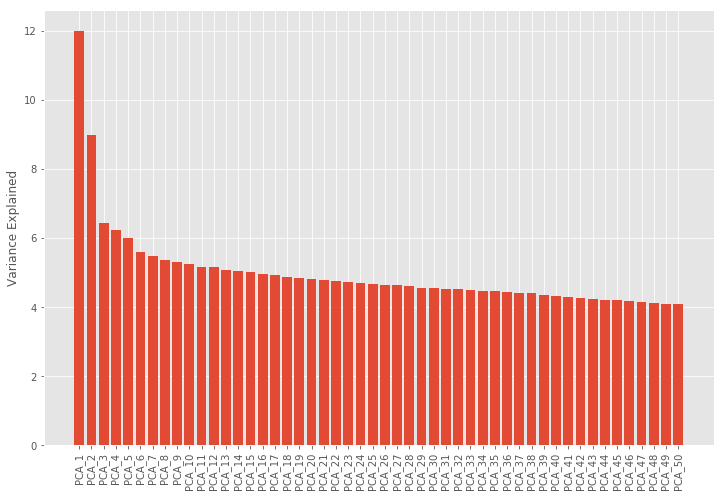

In [66]:
# 50 pca components
plt.figure(figsize = (12, 8))

pca_range = np.arange(n_components) + 1

# Record names 
pca_names = ['PCA_%s' % i for i in pca_range]

plt.bar(pca_range, pca.explained_variance_, align='center')

xticks = plt.xticks(pca_range, pca_names, rotation=90)

plt.ylabel('Variance Explained')

### 5.4 Plot proportion of variance explained with top K principal components

Text(0,0.5,'Variance Explained')

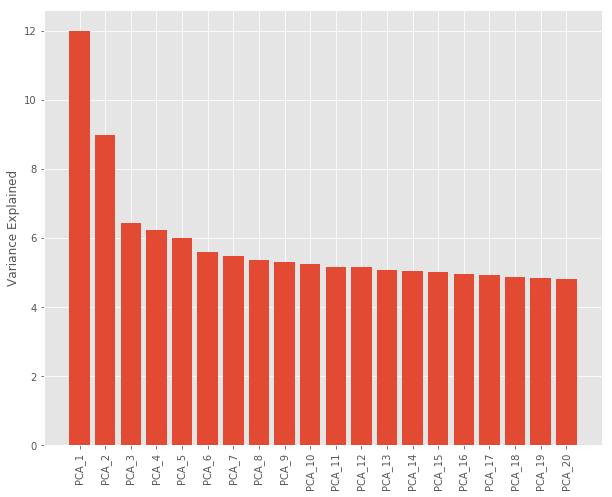

In [67]:
# For a clear display, plot 20 pca components
plt.figure(figsize = (10, 8))

pca_range = np.arange(20) + 1

# Record names 
pca_names = ['PCA_%s' % i for i in pca_range]

# Plot a bar chart by variance
plt.bar(pca_range, pca.explained_variance_[:20], align='center')

xticks = plt.xticks(pca_range, pca_names, rotation=90)

plt.ylabel('Variance Explained')

## 6. Classifying positive/negative review with PCA preprocessing
- 6.1 Logistic Regression Classifier
    - 6.1.1 Use standardized tf-idf vectors as features
    - 6.1.2 Use (Stardardized + PCA) tf-idf vectors as features
    - 6.1.3 Summary
    - 6.1.4 Visualization: PCA components 
- 6.2 Random Forest Classifier
    - 6.2.1 Use standardized tf-idf vectors as features
    - 6.2.2 Use (Stardardized + PCA) tf-idf vectors as features
    - 6.2.3 Summary
    - 6.2.4 Visualization: PCA components

### 6.1 Logistic Regression Classifier

#### 6.1.1 Use standardized tf-idf vectors as features

In [68]:
# Build a Logistic Regression Classifier, train with standardized tf-idf vectors
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(scale_train_X, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# Get the accuracy score for the train set
model.score(scale_train_X, target_train)

0.9992486851990984

In [70]:
# Get the accuracy score for the test set
model.score(scale_test_X, target_test)

0.7087087087087087

#### 6.1.2 Use (Stardardized + PCA) tf-idf vectors as features

In [71]:
# Build a Logistic Regression Classifier, train with PCA tranformed X

from sklearn.linear_model import LogisticRegression

# To be implemented
model = LogisticRegression()
model.fit(train_components, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
# Get score for training set
model.score(train_components, target_train)

0.7798647633358378

In [73]:
# Get score for test set, REMEMBER to use PCA-transformed X!
model.score(test_components, target_test)

0.7657657657657657

#### 6.1.3 Summary
#### Q: What do I observed from the train score and the test score? What's the difference between the results from PCA and non-PCA preprocessing?
A: Using only standardized tf-idf in the Logistic model produced an overfitting result from the train score to the test score, since the difference between the two datasets is very large, from 0.99 to 0.70. Using standardized pca components in the Logistic model produced a more steady result, the scores changed from 0.78 to 0.76.

#### 6.1.4 Visualization: PCA components 

In [74]:
# 50 pca components
pca_range = np.arange(n_components) + 1

# Record names 
pca_names = ['PCA_%s' % i for i in pca_range]

In [75]:
df_coeffs = pd.DataFrame(list(zip(pca_names, model.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
3,PCA_4,0.307776
5,PCA_6,0.167969
6,PCA_7,0.139959
8,PCA_9,0.106775
4,PCA_5,0.091399
41,PCA_42,0.051576
13,PCA_14,0.050884
35,PCA_36,0.043537
29,PCA_30,0.034106
39,PCA_40,0.029215


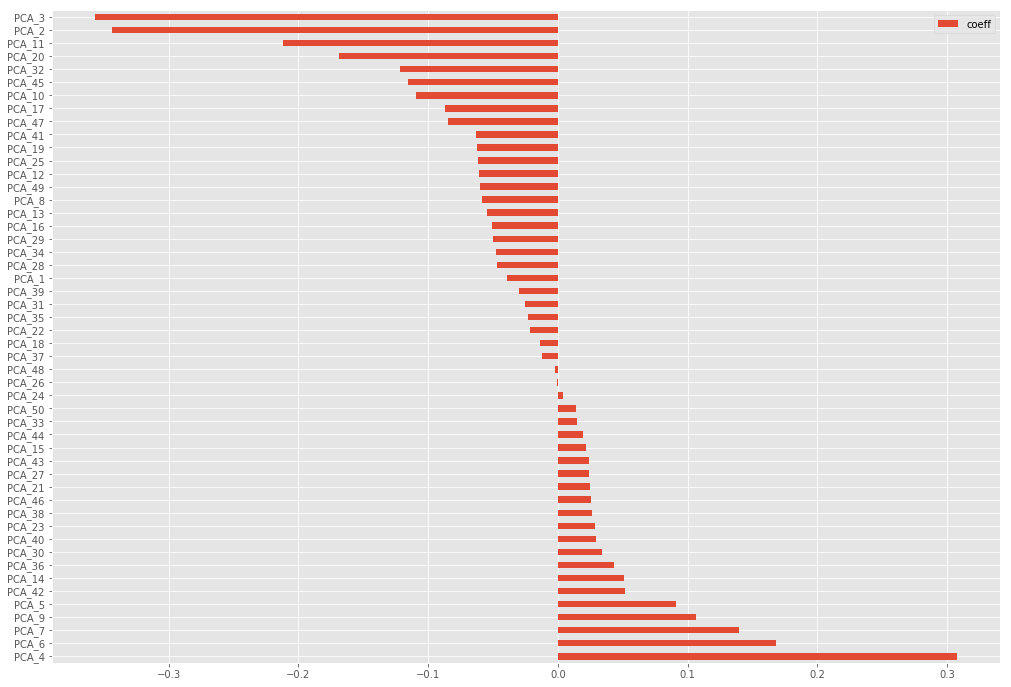

In [76]:
# plot a bar chart of coefficients against principal components 
ax = df_coeffs.plot.barh(figsize = (17,12))
t = np.arange(50)
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

### 6.2 Random Forest Classifier

#### 6.2.1 Use standardized tf-idf vectors as features

In [77]:
# Build a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_leaf = 5, random_state = 1)
model.fit(scale_train_X, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [78]:
# Get the accuracy score for the train set
model.score(scale_train_X, target_train)

0.8858001502629602

In [79]:
# Get the accuracy score for the test set
model.score(scale_test_X, target_test)

0.7477477477477478

#### 6.2.2 Use (Stardardized + PCA) tf-idf vectors as features

In [80]:
# Build a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_leaf = 5, random_state = 1)
model.fit(train_components, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [81]:
# Get the accuracy score for the train set
model.score(train_components, target_train)

0.9729526671675433

In [82]:
# Get the accuracy score for the test set
model.score(test_components, target_test)

0.7207207207207207

#### 6.2.3 Summary
#### Q: What do I observe from the train result and the test result?

A: 
1. In Random Forest 
    - Using only standardized tf-idf in the Random Forest model produced a more steady result. The scores changed from 0.89 to 0.75, but it's still a big difference between train and test score.
    - However, previously we saw using standardized pca components in the Logistic model reduced an overfitting issue, but in this time using standardized pca components in the Random Forest model can't help us solve the problem. Moreover, using standardized pca components provides a more unstable result which is more serious compared with using only standardized tf-idf.
2. Between Logistic and Random Forest
    - In general, using standardized pca components in a steady model, such as Logistic model through this example is a favorable choice to start. For a high-variance model, such as Random Forest, both methods, using only standardized tf-idf and using standardized pca components, can't work well as we expected. 
    - In a detailed summary, if reduce the number of variables in a Logistic model, or equivalently using 50 standardized pca components, we can improve an overfitting issue because of a simpler Logistic model. On the other hand, the goal of the Random Forest is to lower down an overall variance by randomly using a portion of features to generate each tree structure seperately. Using a less number of pca components can lead to an issue that each tree structure is more likely to be the same with other trees' structures. Therefore, using a less number of pca components results in an overfitting issue.

#### 6.2.4 Visualization: PCA components

In [83]:
# 50 pca components
pca_range = np.arange(n_components) + 1

# Record names 
pca_names = ['PCA_%s' % i for i in pca_range]

In [84]:
# Create a dataframe containing feature importances provided by the Random Forest
df_coeffs = pd.DataFrame(list(zip(pca_names, model.feature_importances_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
1,PCA_2,0.094642
2,PCA_3,0.087672
3,PCA_4,0.069740
5,PCA_6,0.039372
6,PCA_7,0.027173
9,PCA_10,0.026610
10,PCA_11,0.026109
8,PCA_9,0.022177
4,PCA_5,0.021256
46,PCA_47,0.020999


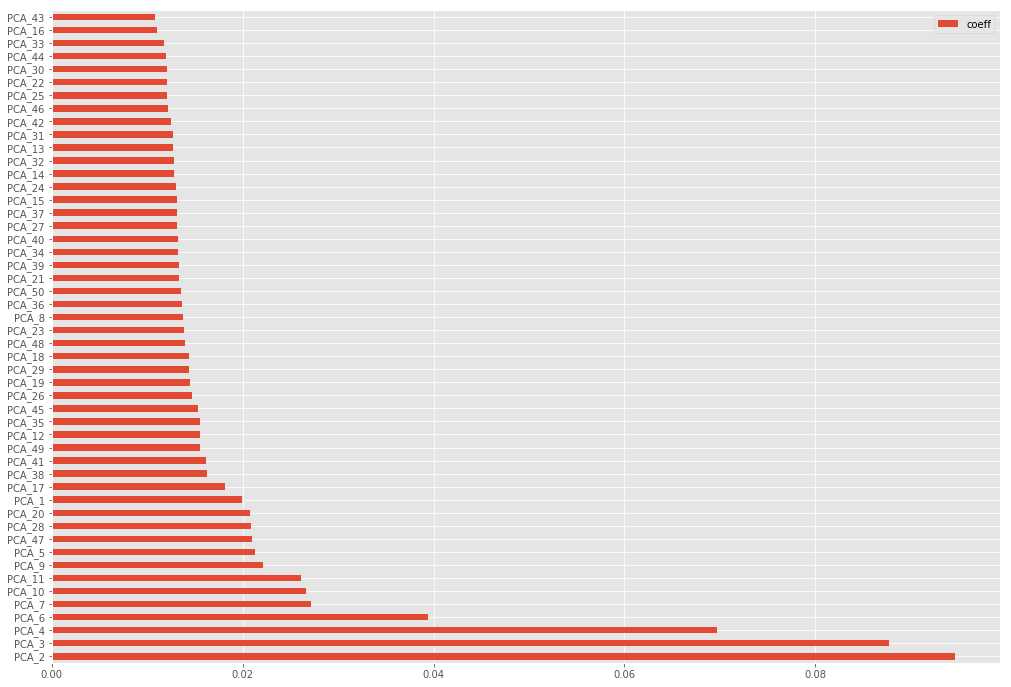

In [85]:
# Bar chart: plot coefficients of pca components
ax = df_coeffs.plot.barh(figsize = (17,12))
t = np.arange(50)
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

## 7. Other improvements for this notebook
This notebook could further include:
1. Cluster restaurants from their category information
    - How? Hint: A business may have mutiple categories, e.g. a restaurant can have both "Restaurants" and "Korean".
2. Try different distance/similarity metrics for clusterings, e.g. Pearson correlation, Jaccard distance, etc.
    - Take a look at [scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)  documentations to use other distances.
3. Cluster categories from business entities.
    - How? Hint: Think the example where words can be clustered from the transposed tf-idf matrix.
4. What are the characteristics of each of the clustered ? For each cluster, which restaurant can best represent ("define") its cluster?